In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

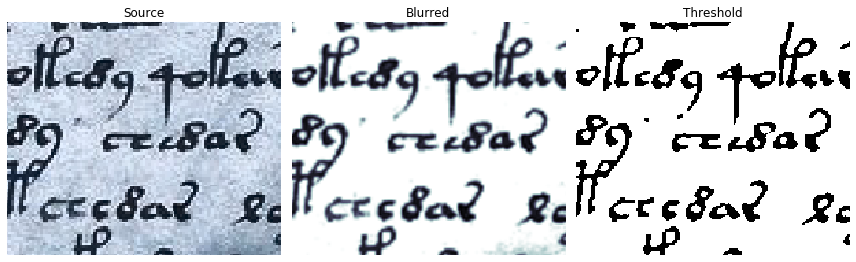

In [2]:
pth = '/home/tony/voynich/png/easy/clean/'
fn = 'img-203c.png'
image = cv2.imread(pth+fn)

kernel = np.ones((1, 1), np.uint8)

def clean(img):
    img = cv2.cvtColor(img ,cv2.COLOR_BGR2GRAY)
    img = cv2.multiply(img, 1.5)
    blr = cv2.GaussianBlur(img, (3, 3), 0)
    thres = cv2.adaptiveThreshold(blr, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 40)
    thres = cv2.dilate(thres, kernel, iterations=1)
    return  [blr, thres]
    
gray, thresh = clean(image)

_, axs = plt.subplots(1, 3, figsize=(12, 6))
axs[0].imshow(image[300:470,500:700], cmap=plt.cm.bone)
axs[0].set_title('Source')
axs[1].imshow(gray[300:470,500:700], cmap=plt.cm.bone)
axs[1].set_title('Blurred')
axs[2].imshow(thresh[300:470,500:700], cmap=plt.cm.bone)
axs[2].set_title('Threshold')

for ax in axs:
        ax.axis('off')
        
plt.tight_layout()
plt.show()

In [3]:
Gmx = 64
Gmn = 24

In [4]:
def fits(b):
    return b[2] > Gmn and b[3] > Gmn and b[2] < Gmx-2 and b[3] < Gmx-2 and b[0] > 0 and b[1] > 0
    
def cut(img, b, c):
    roi = img[b[1]-1:b[1]+b[3]+2, b[0]-1:b[0]+b[2]+2]
    hc, wc = roi.shape
    delta_w = Gmx - wc
    delta_h = Gmx - hc
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    mask = 255 * np.ones(shape=[hc, wc], dtype=np.uint8)
    mask = cv2.drawContours(mask, [ c - ( b[0] - 1, b[1] - 1 ) ], -1, 0,-1)
    masked = np.where(mask==0, roi, 255)
    masked = cv2.GaussianBlur(masked, (5, 5), 0)
    #masked = cv2.copyMakeBorder(masked, top, bottom, left, right, cv2.BORDER_CONSTANT, value=255)
    return masked


clahe = cv2.createCLAHE(clipLimit=40.0, tileGridSize=(8,8))

def parse(path, src):
    a = []
    i = 0
    image = cv2.imread(path+src)
    gray, thresh = clean(image)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        bound = cv2.boundingRect(contour)
        if fits(bound):
            mask = cut(gray, bound, contour)
            mask = cv2.equalizeHist(mask)
            #mask = clahe.apply(mask)
            a.append([i, src, mask, bound, contour])
            i+=1
    return a

result = parse(pth, fn)
print(len(result), " characters")

451  characters


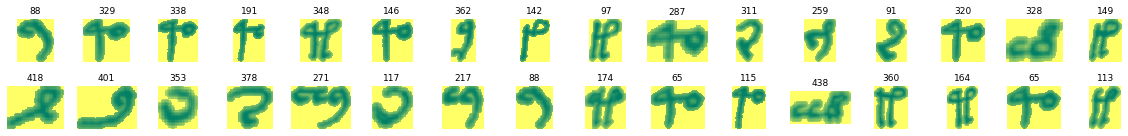

In [5]:
import random

r,c = (2,16)
_, axs = plt.subplots(r, c, figsize=(c,r))
for i,r in [(_,random.randrange(len(result))) for _ in range(r*c)]:
    id, src, mask, bound, contour = result[r]
    ax = axs[int(i/c), i%c]
    ax.imshow(mask, cmap=plt.cm.summer)
    ax.set_title(r, fontsize=9)
    ax.axis('off')
plt.tight_layout()

In [6]:
key_size = 60

pca_data = []
images =[]
for id, src, mask, bound, contour in result:
    pca_data.append(cv2.resize(mask, (key_size, key_size)).flatten())
    images.append(mask)

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

n_components = 16

scaler = StandardScaler()
scaler.fit(pca_data)
sdt = scaler.transform(pca_data)
pca = PCA(n_components = n_components, copy=True, whiten=True)
projected = pca.fit_transform(sdt)
EPR = pca.explained_variance_ratio_

print('Components:', len(EPR))
print(np.round(EPR[:10]*100, 1))
print(str(np.round(sum(EPR[:10])*100,2))+'%')

Components: 16
[18.  13.3  8.6  6.5  5.3  4.5  4.   3.2  2.9  2.3]
68.52%


In [8]:
from sklearn.cluster import KMeans

n_clusters_ = 24

kmeans = KMeans( n_clusters=n_clusters_, max_iter=500, n_init=50).fit(projected)

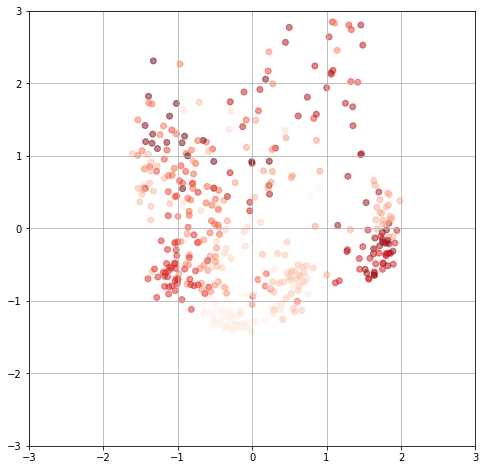

In [9]:
_, axs = plt.subplots(1, 1, figsize=(8, 8))
axs.scatter(projected[:, 0], projected[:, 1], c=kmeans.labels_, alpha=0.5, cmap='Reds') 
#axs.scatter(projected[:, 1], projected[:, 2], c=kmeans.labels_, alpha=0.3, cmap='Blues') 
#axs.scatter(projected[:, 2], projected[:, 3], c=kmeans.labels_, alpha=0.2, cmap='Greens') 
f = 3
plt.xlim((-f, f))
plt.ylim((-f, f))
plt.grid(True)
plt.show()

In [10]:
q={}
for img, lbl in zip(images, kmeans.labels_):
    if not lbl in q:
        q[lbl] = [img]
    else:
        q[lbl].append(img)
#'''for k in sorted(q.keys()):
#    if(len(q[k])) > 1:
#        print(k,len(q[k]))'''

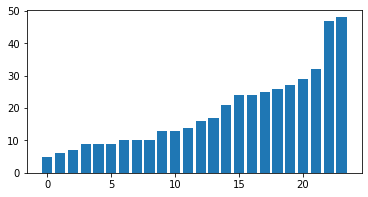

In [11]:
_, axs = plt.subplots(1, 1, figsize=(6,3))
k = sorted([len(q[k]) for k in q.keys()])
axs.bar(range(len(q.keys())), k)
plt.show()

14


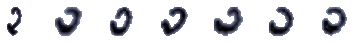

In [12]:
r,c = (2,16)
clst = q[14]
print(len(clst))
plt.figure(figsize=(c*0.75, len(clst)/20))
for i, img in enumerate(clst[:int(len(clst)/2)]):
    plt.subplot(len(clst) / c + 1, c, i + 1)
    plt.imshow(img, cmap=plt.cm.bone)
    plt.gca().set_axis_off()
plt.tight_layout()
plt.show()

In [35]:
def make_edges(da, db, level):
    v = []
    i = 0
    da = list(da)
    db = list(db)
    for di in da:
        j = 0
        for dj in db:
            if i < j:
                x0,y0 = di
                x1,y1 = dj
                d = np.sqrt(np.power(x0-x1,2) + np.power(y0-y1,2)) * level
                v.append([i,j,d])
            j = j + 1
        i = i + 1
    return v
            
E = []

for n in range(0,1):
    E = E + make_edges( zip(projected[:,n], projected[:,n+1]), zip(projected[:,n+1], projected[:,n+2]), 1.0)

print(len(E))

101475


[0]

101475


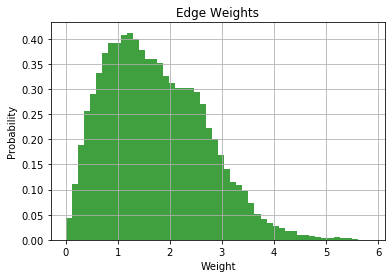

In [43]:
de = {}
for i,j,v in E:
    k = (i,j)
    if k in de:
        de[k] += v
    else:
        de[k] = v
        
aa = []
for k in de:
    aa.append([k[0],k[1],de[k]])
    
print(len(aa))

n, bins, patches = plt.hist([_[2] for _ in aa], 50, density=True, facecolor='g', alpha=0.75)
plt.xlabel('Weight')
plt.ylabel('Probability')
plt.title('Edge Weights')
plt.grid(True)
plt.show()

In [44]:
import math

ee = aa[:].copy()
len(ee)

101475

14134


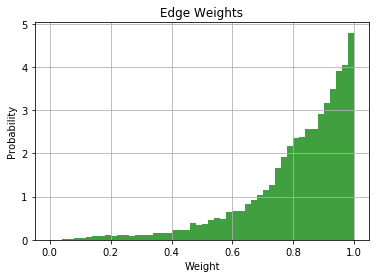

In [45]:
ee = [_ for _ in ee if _[2] > 2.8]

mn = min([_[2] for _ in ee])
for e in ee:
    e[2] = e[2] - (mn*0.9999)
mx = max([_[2] for _ in ee])
for e in ee:
    e[2] = 1-(e[2] / mx)
    
print(len(ee))

n, bins, patches = plt.hist([_[2] for _ in ee], 50, density=True, facecolor='g', alpha=0.75)
plt.xlabel('Weight')
plt.ylabel('Probability')
plt.title('Edge Weights')
plt.grid(True)
plt.show()

In [46]:
import csv

with open('/var/www/html/vv/Edges.csv', mode='w') as ef:
    ew = csv.writer(ef, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    fieldnames = ['source', 'target', 'weight']
    dw = csv.DictWriter(ef, fieldnames=fieldnames)
    dw.writeheader()
    for e in ee:
        na,nb,w = e
        ew.writerow([na,nb,w])

N = [_[0] for _ in ee] + [_[1] for _ in ee]
ns = set(N)
N = list(ns)
print(len(N))

with open('/var/www/html/vv/Nodes.csv', mode='w') as ef:
    ew = csv.writer(ef, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    fieldnames = ['ID']
    dw = csv.DictWriter(ef, fieldnames=fieldnames)
    dw.writeheader()
    for n in N:
        ew.writerow([n])
        
id = 0;
for id, src, mask, bound, contour in result:
    fp = "/var/www/html/vv/glyphs/" + str(id) + ".png"
    cv2.imwrite(fp, mask)
print(id)

451
450


In [18]:
id, src, mask, bound, contour = result[841]
_, axs = plt.subplots(1, 1, figsize=(2, 2))
plt.imshow(mask, cmap=plt.cm.bone)
plt.gca().set_axis_off()
plt.tight_layout()
plt.show()

IndexError: list index out of range

In [ ]:
id = 0;
for id, src, mask, bound, contour in result:
    fp = "/var/www/html/vv/glyphs/" + str(id) + ".png"
    cv2.imwrite(fp, mask)
print(id)